In [10]:
#Import Library
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import numpy as np
import os
import matplotlib.pyplot as plt

#Define Hyperparameters
train_path = '/Users/aqsal/Downloads/FINALPROJECT/finpro-fraud/p2-final-project-signature-detector/dataset/dataset2/processed_train'
test_path = '/Users/aqsal/Downloads/FINALPROJECT/finpro-fraud/p2-final-project-signature-detector/dataset/dataset2/processed_test'

img_height = 224  # Ukuran gambar
img_width = 224  # Ukuran gambar
batch_size = 16  # Jumlah sampel per batch

#Data Augmentation dan Data Generator
train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.4)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height, img_width),
                                              class_mode='sparse',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=10)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(img_height, img_width),
                                            class_mode='sparse',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=10)

test_datagen = ImageDataGenerator(rescale=1./255.)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height, img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=10)

#Load Pretrained MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Freeze layer pretrained
base_model.trainable = False

#Tambahkan Fully Connected Layers
modelmobile = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_set.class_indices), activation='softmax')
])

#Compile Model
modelmobile.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

#Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Training Model
historymobilenet = modelmobile.fit(
    train_set,
    validation_data=val_set,
    epochs=150,  # Mulai dengan 150 epoch, bisa dihentikan lebih awal dengan EarlyStopping
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Found 969 images belonging to 33 classes.
Found 615 images belonging to 33 classes.
Found 726 images belonging to 33 classes.
Epoch 1/150


/Users/aqsal/miniforge3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 261ms/step - accuracy: 0.0354 - loss: 3.8802 - val_accuracy: 0.3252 - val_loss: 2.8957
Epoch 2/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step - accuracy: 0.1629 - loss: 3.1003 - val_accuracy: 0.4878 - val_loss: 2.3336
Epoch 3/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 263ms/step - accuracy: 0.3221 - loss: 2.6336 - val_accuracy: 0.7951 - val_loss: 1.8017
Epoch 4/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 289ms/step - accuracy: 0.4667 - loss: 2.2230 - val_accuracy: 0.9073 - val_loss: 1.3442
Epoch 5/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 269ms/step - accuracy: 0.5507 - loss: 1.8689 - val_accuracy: 0.9398 - val_loss: 0.9887
Epoch 6/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.6289 - loss: 1.5195 - val_accuracy: 0.9675 - val_loss: 0.7284
Epoch 7/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.7448 - loss: 1.2800 - val_accuracy: 0.9772 - val_loss: 0.5471
Epoch 8/150
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.7869 - loss: 1.0812 - val_accuracy

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.8737 - loss: 0.5627
Test Loss: 0.8272
Test Accuracy: 0.8306


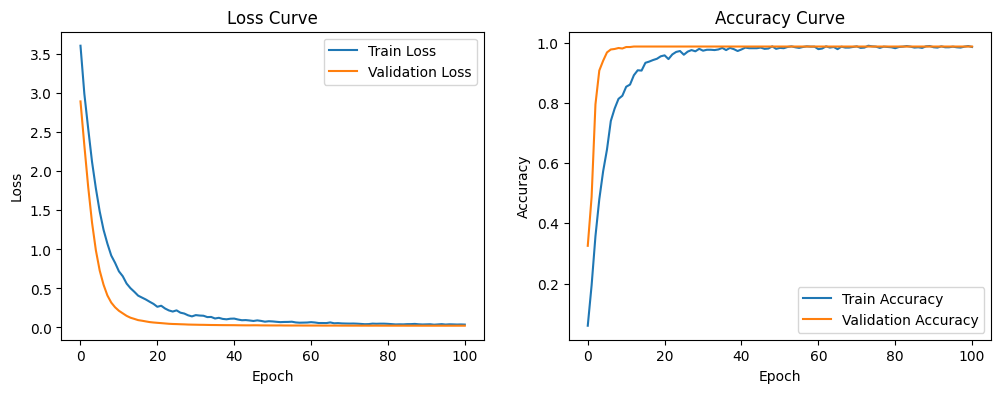

In [11]:
#Evaluasi Model
test_loss, test_accuracy = modelmobile.evaluate(test_set)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

#Visualisasi Hasil Training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historymobilenet.history['loss'], label='Train Loss')
plt.plot(historymobilenet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(historymobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(historymobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

In [12]:
#Classification Report dan Confusion Matrix
#import Machine Learning
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


y_true = test_set.classes
y_pred = modelmobile.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(test_set.class_indices.keys())))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step
Classification Report:
                           precision    recall  f1-score   support

             Affan Haidar       1.00      1.00      1.00        22
              Ainun Putri       0.76      1.00      0.86        22
          Andi ahmad afiq       1.00      1.00      1.00        22
    Andi. Dwi Yuniarti. H       0.62      0.82      0.71        22
                 Bayu Adi       0.78      0.82      0.80        22
       Dewi Titania Randa       0.92      1.00      0.96        11
           Dinda unidayan       0.84      0.95      0.89        22
              Dwi Octavia       0.95      0.95      0.95        22
                    Fadli       0.80      0.36      0.50        22
        Fildzah Khalishah       0.89      0.77      0.83        22
           Fiqram Faathir       0.96      1.00      0.98        22
                    Githa       0.85      0.50      0.63        22
         Hashimatul Zaria       0.96      1.00      0.98        

In [13]:
# frezz parameter untuk tidak di edit lagi parameter model nya terhadap train.fit
# freeze params

modelmobile.trainable = False
modelmobile.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 33)             │         8,481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,237 (12.46 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,594,401 (9.90 MB)

 Optimizer params: 672,836 (2.57 MB)

In [14]:
#Simpan Model
modelmobile.save("signature_model_mobilenetv2.h5")
print("Model disimpan")

#Prediksi Tanda Tangan Baru
def predict_signature(image_path, model, class_indices):
    """
    Melakukan prediksi terhadap gambar tanda tangan baru.
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    class_label = list(class_indices.keys())[predicted_class]
    
    print(f"Prediksi: {class_label}")
    return class_label

Model disimpan


In [15]:
from tensorflow.keras.preprocessing import image
from PIL import Image


def predict_image_path(image_url, modelmobile, train_set):
    try:
        # Load gambar & konversi ke RGB
        img = Image.open(image_url).convert("RGB")  # **Convert ke RGB**
        img = img.resize((224, 224))  # Sesuaikan dengan input model
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalisasi

        # Prediksi dengan model
        prediction = modelmobile.predict(img_array)
        predicted_class = np.argmax(prediction[0])
        confidence = prediction[0][predicted_class] * 100

        # Ambil nama kelas dari dataset
        class_labels = list(train_set.class_indices.keys())
        predicted_label = class_labels[predicted_class]

        return f"Predicted class: {predicted_label}, Confidence: {confidence:.2f}%"

    except Exception as e:
        return f"Error during prediction: {e}"

# Contoh pemanggilan fungsi
image_url = "/Users/aqsal/Downloads/FINALPROJECT/finpro-fraud/p2-final-project-signature-detector/dataset/dataset2/test/Affan Haidar/20250217_145003.jpg"  # Ganti dengan path gambar lokal
result = predict_image_path(image_url, modelmobile, train_set)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
Predicted class: Affan Haidar, Confidence: 98.18%


In [16]:

print(train_set.class_indices)
print(test_set.class_indices)

{'Affan Haidar': 0, 'Ainun Putri': 1, 'Andi ahmad afiq': 2, 'Andi. Dwi Yuniarti. H': 3, 'Bayu Adi': 4, 'Dewi Titania Randa': 5, 'Dinda unidayan': 6, 'Dwi Octavia': 7, 'Fadli': 8, 'Fildzah Khalishah': 9, 'Fiqram Faathir': 10, 'Githa': 11, 'Hashimatul Zaria': 12, 'Ikbal': 13, 'Inka Sinulingga': 14, 'Ishaq usn': 15, 'Khairunnisa': 16, 'Laode Sandi Yunus': 17, 'Lia Kurniawati': 18, 'Lithania': 19, 'Mariati unidayan': 20, 'Mas Bilal': 21, 'Mohammad Rachman': 22, 'Muh Luthfi': 23, 'Muh. Falah Mubaraq': 24, 'Muhammad Azriel Saktiawan': 25, 'Mursawal': 26, 'Ni Luh Ica Ardini': 27, 'Ni Made Sri Ulandari': 28, 'Nur Ilmi Fadilah': 29, 'Prety Maharani Utami': 30, 'Putri Angraini Aziz': 31, 'Putu Riva': 32}
{'Affan Haidar': 0, 'Ainun Putri': 1, 'Andi ahmad afiq': 2, 'Andi. Dwi Yuniarti. H': 3, 'Bayu Adi': 4, 'Dewi Titania Randa': 5, 'Dinda unidayan': 6, 'Dwi Octavia': 7, 'Fadli': 8, 'Fildzah Khalishah': 9, 'Fiqram Faathir': 10, 'Githa': 11, 'Hashimatul Zaria': 12, 'Ikbal': 13, 'Inka Sinulingga': 14

-------